### Importing Libraries

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [ ]:
# Set dataset path
base_dir = '/content/drive/MyDrive/Discipline Specific /4th Model/Preprocessed Non Cancerous '

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-4
NUM_CLASSES = 4           # e.g., vasc, nv, df, bkl

# 2. DATA GENERATORS (NO EXTRA AUGMENTATION)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% for validation
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Print the mapping to verify (example: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3})
print("Class indices:", train_generator.class_indices)

# Define class weights
class_weight = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'bkl': 0, 'df': 1, 'nv': 2, 'vasc': 3}


### Building the VGG16 Model - 50 Epochs, No Early Stopping
Model Structure:
- **Base Model:** VGG16 (Pretrained on ImageNet, Excludes Fully Connected Layers)
  - Conv Block 1: 2 Conv Layers → MaxPooling
  - Conv Block 2: 2 Conv Layers → MaxPooling
  - Conv Block 3: 3 Conv Layers → MaxPooling
  - Conv Block 4: 3 Conv Layers → MaxPooling
  - Conv Block 5: 3 Conv Layers → MaxPooling
  - Output: Feature maps from final convolutional layer

- **Custom Classification Head:**
  - Global Average Pooling Layer (Reduces feature maps to a single 1D vector)
  - Fully Connected Layer (1024 neurons, ReLU activation, L2 regularization)
  - Dropout Layer (60% dropout to reduce overfitting)
  - Output Layer (Softmax activation for multi-class classification)

- **Training Phases:**
  - **Phase 1 (Feature Extraction):** Freeze all VGG16 layers, train only the classification head.
  - **Phase 2 (Fine-Tuning):** Unfreeze last convolutional block (block5_), update selected layers with a lower learning rate

In [ ]:
# Load VGG16 with ImageNet weights (excluding the fully connected top layers)
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers to retain pretrained features during initial training
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classification head with added regularization to reduce overfitting
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to a 1D feature vector
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.6)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the complete model combining VGG16 and the custom head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model for the initial training phase
optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

#############################
# TRAINING - PHASE 1 WITHOUT EARLY STOPPING
#############################

# Save the best model during training based on validation accuracy
checkpoint = ModelCheckpoint('best_model_vgg16_phase1.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Removed early stopping
callbacks_list = [checkpoint]

# Train the model using class weights to handle class imbalance
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,  # Only checkpoint callback is used now
    class_weight=class_weight  # Adjust class importance during training
)

#############################
# FINE-TUNING (PHASE 2) WITHOUT EARLY STOPPING
#############################

# Unfreeze only the last convolutional block ('block5_') for fine-tuning
for layer in base_model.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True

# Recompile the model with a lower learning rate to fine-tune the last layers
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR prevents drastic weight updates
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save the best fine-tuned model based on validation accuracy
checkpoint_ft = ModelCheckpoint('best_model_vgg16_finetune.h5',
                                monitor='val_accuracy',
                                save_best_only=True,
                                mode='max',
                                verbose=1)

# Removed early stopping for fine-tuning phase
callbacks_list_ft = [checkpoint_ft]

# Continue training for fine-tuning with additional epochs
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=20,  # Increased fine-tuning epochs to 20
    callbacks=callbacks_list_ft,
    class_weight=class_weight  # Apply class weights during fine-tuning as well
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3876 - loss: 2.4418 
Epoch 1: val_accuracy improved from -inf to 0.71750, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 2581s 26s/step - accuracy: 0.3888 - loss: 2.4355 - val_accuracy: 0.7175 - val_loss: 0.8147
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6992 - loss: 1.0407
Epoch 2: val_accuracy improved from 0.71750 to 0.77500, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.6994 - loss: 1.0399 - val_accuracy: 0.7750 - val_loss: 0.6433
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7832 - loss: 0.7497
Epoch 3: val_accuracy improved from 0.77500 to 0.80375, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - accuracy: 0.7833 - loss: 0.7491 - val_accuracy: 0.8037 - val_loss: 0.6651
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.8142 - loss: 0.6374
Epoch 4: val_accuracy improved from 0.80375 to 0.82750, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.8142 - loss: 0.6370 - val_accuracy: 0.8275 - val_loss: 0.5611
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8373 - loss: 0.5181
Epoch 5: val_accuracy improved from 0.82750 to 0.82875, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step - accuracy: 0.8373 - loss: 0.5182 - val_accuracy: 0.8288 - val_loss: 0.5715
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8611 - loss: 0.4658
Epoch 6: val_accuracy improved from 0.82875 to 0.84750, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.8611 - loss: 0.4656 - val_accuracy: 0.8475 - val_loss: 0.5137
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8872 - loss: 0.4051
Epoch 7: val_accuracy improved from 0.84750 to 0.85125, saving model to best_model_vgg16_phase1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - accuracy: 0.8871 - loss: 0.4051 - val_accuracy: 0.8512 - val_loss: 0.4916
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8951 - loss: 0.3618
Epoch 8: val_accuracy did not improve from 0.85125
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 322ms/step - accuracy: 0.8951 - loss: 0.3618 - val_accuracy: 0.8512 - val_loss: 0.5221
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9012 - loss: 0.3263
Epoch 9: val_accuracy did not improve from 0.85125
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 355ms/step - accuracy: 0.9013 - loss: 0.3263 - val_accuracy: 0.8450 - val_loss: 0.4954
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9158 - loss: 0.3171
Epoch 10: val_accuracy did not improve from 0.85125
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - accuracy: 0.9157 - loss: 0.3171 - val_accuracy: 0.8462 - val_loss: 0.4754
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9196 - loss: 0.2846
Epoch 11: va

100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.9253 - loss: 0.2496 - val_accuracy: 0.8525 - val_loss: 0.4722
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9240 - loss: 0.2634
Epoch 13: val_accuracy did not improve from 0.85250
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 325ms/step - accuracy: 0.9241 - loss: 0.2633 - val_accuracy: 0.8413 - val_loss: 0.5176
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9349 - loss: 0.2606
Epoch 14: val_accuracy did not improve from 0.85250
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 309ms/step - accuracy: 0.9349 - loss: 0.2606 - val_accuracy: 0.8388 - val_loss: 0.4825
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9362 - loss: 0.2458
Epoch 15: val_accuracy did not improve from 0.85250
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 314ms/step - accuracy: 0.9362 - loss: 0.2458 - val_accuracy: 0.8487 - val_loss: 0.4702
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9407 - loss: 0.2322
Epoch 16

100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 315ms/step - accuracy: 0.9767 - loss: 0.1506 - val_accuracy: 0.8612 - val_loss: 0.4731
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9708 - loss: 0.1553
Epoch 26: val_accuracy did not improve from 0.86125
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.9708 - loss: 0.1553 - val_accuracy: 0.8450 - val_loss: 0.5008
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9744 - loss: 0.1428
Epoch 27: val_accuracy did not improve from 0.86125
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.9744 - loss: 0.1429 - val_accuracy: 0.8612 - val_loss: 0.4441
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9698 - loss: 0.1550
Epoch 28: val_accuracy did not improve from 0.86125
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 323ms/step - accuracy: 0.9698 - loss: 0.1550 - val_accuracy: 0.8537 - val_loss: 0.4545
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9801 - loss: 0.1362
Epoch 29

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - accuracy: 0.9922 - loss: 0.0953 - val_accuracy: 0.8662 - val_loss: 0.4423
Epoch 47/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9904 - loss: 0.0928
Epoch 47: val_accuracy did not improve from 0.86625
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.9904 - loss: 0.0928 - val_accuracy: 0.8487 - val_loss: 0.4924
Epoch 48/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9941 - loss: 0.0920
Epoch 48: val_accuracy did not improve from 0.86625
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 361ms/step - accuracy: 0.9941 - loss: 0.0920 - val_accuracy: 0.8462 - val_loss: 0.4816
Epoch 49/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9949 - loss: 0.0911
Epoch 49: val_accuracy did not improve from 0.86625
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 313ms/step - accuracy: 0.9949 - loss: 0.0912 - val_accuracy: 0.8512 - val_loss: 0.4731
Epoch 50/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9958 - loss: 0.0841
Epoch 50

100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step - accuracy: 0.9876 - loss: 0.0994 - val_accuracy: 0.8750 - val_loss: 0.4062
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9937 - loss: 0.0782
Epoch 2: val_accuracy did not improve from 0.87500
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.9937 - loss: 0.0782 - val_accuracy: 0.8425 - val_loss: 0.8364
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9909 - loss: 0.0815
Epoch 3: val_accuracy did not improve from 0.87500
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 326ms/step - accuracy: 0.9909 - loss: 0.0815 - val_accuracy: 0.8438 - val_loss: 0.6341
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9962 - loss: 0.0718
Epoch 4: val_accuracy did not improve from 0.87500
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.9962 - loss: 0.0718 - val_accuracy: 0.8450 - val_loss: 0.5791
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9959 - loss: 0.0709
Epoch 5: val_ac

100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - accuracy: 0.9997 - loss: 0.0577 - val_accuracy: 0.8800 - val_loss: 0.4273
Epoch 19/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9987 - loss: 0.0588
Epoch 19: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 319ms/step - accuracy: 0.9987 - loss: 0.0588 - val_accuracy: 0.8462 - val_loss: 0.7731
Epoch 20/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9988 - loss: 0.0594
Epoch 20: val_accuracy did not improve from 0.88000
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 324ms/step - accuracy: 0.9989 - loss: 0.0594 - val_accuracy: 0.8575 - val_loss: 0.5271


### Evaluation Metrics - Performance of the Model

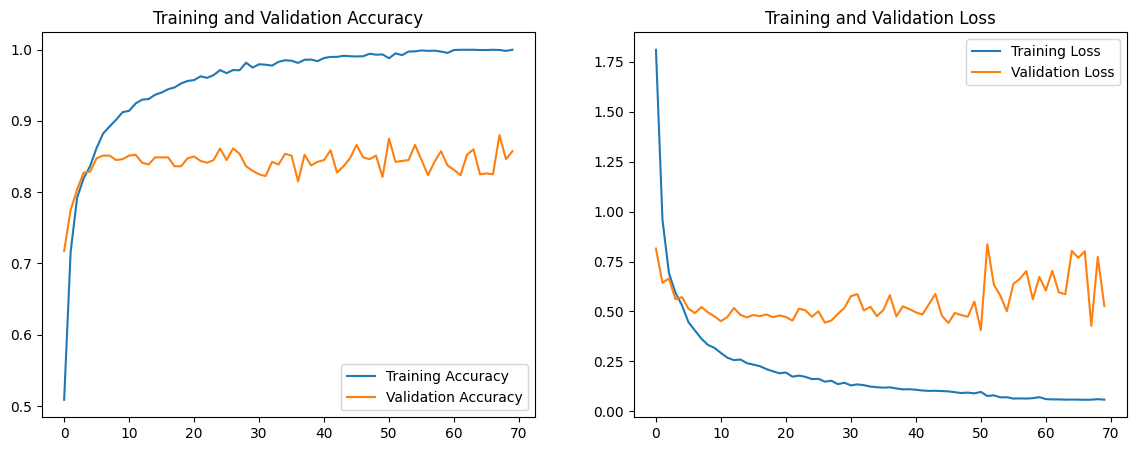

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step


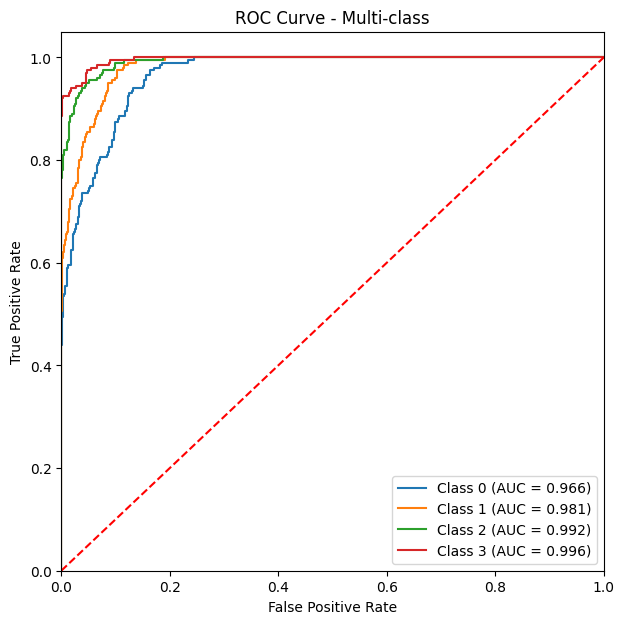

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step
Confusion Matrix:
[[161   0  20  19]
 [ 44 147   6   3]
 [  3   5 188   4]
 [  0   8   2 190]]


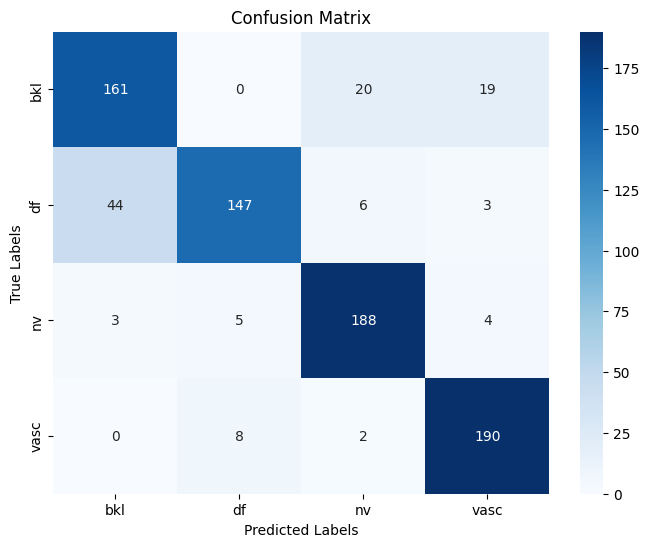

Classification Report:
              precision    recall  f1-score   support

         bkl       0.77      0.81      0.79       200
          df       0.92      0.73      0.82       200
          nv       0.87      0.94      0.90       200
        vasc       0.88      0.95      0.91       200

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



In [ ]:


#############################
# PLOT ACCURACY & LOSS
#############################
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#############################
# EVALUATE AUC-ROC
#############################
valid_generator.reset()
y_pred_proba = model.predict(valid_generator)
y_true = valid_generator.classes
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
plt.figure(figsize=(7, 7))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.3f})'.format(i, roc_auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()

#############################
# CONFUSION MATRIX & CLASSIFICATION REPORT
#############################
valid_generator.reset()
steps = math.ceil(valid_generator.samples / valid_generator.batch_size)
y_pred = model.predict(valid_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)
# Create a list for class labels based on the generator mapping
class_labels = [None] * len(train_generator.class_indices)
for label, idx in train_generator.class_indices.items():
    class_labels[idx] = label
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)


### Validation Accuracy for the Best Model

In [ ]:
valid_generator.reset()
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy from Model Evaluation: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.8426 - loss: 0.5719
Validation Accuracy from Model Evaluation: 0.8575
